Wavelets are a fundamental part of modern signal processing and feature engineering. Utilizing well developed basis functions with certain mathematical properties, rather than the more typical sines and cosines used for the DFT (discrete fourier transform) and DCT (discrete cosine transform), wavelet analysis has many interesting applications.
<!-- TEASER_END -->

Wavelets have been used extensively for [denoising](https://www.ceremade.dauphine.fr/~peyre/numerical-tour/tours/denoisingwav_1_wavelet_1d/) and [compression](http://www.seas.gwu.edu/~ayoussef/papers/FingerPrintWSQ-chapter.pdf), but the DFT and DCT have been used extensively in these areas as well. One unique area where wavelets shine is *peak detection*. While many peak detection algorithms are based on heuristics, and are often datset specfic, wavelets provide a good framework for generalized peak search. This will be discussed in greater detail after the break.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Data
----
[Sunspots](http://www.quandl.com/SIDC/SUNSPOTS_A-Sunspot-Numbers-Annual) are a typical dataset for testing different peak detection algorithms. Besides having well defined, Gaussian-ish peaks, the height of the local maxima and minima are also variant over time. These attributes make sunspot datasets good for baselining different peak detection algorithms.

sunspots.csv already downloaded!


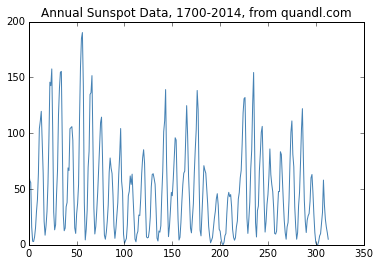

In [2]:
from utils import progress_bar_downloader
import os

link = 'http://www.quandl.com/api/v1/datasets/SIDC/SUNSPOTS_A.csv?&trim_start=1700-12-31&trim_end=2013-12-31&sort_order=desc'
dlname = 'sunspots.csv'
if not os.path.exists('./%s' % dlname):
    progress_bar_downloader(link, dlname)
else:
    print('%s already downloaded!' % dlname)
    
sunspot = np.genfromtxt(dlname, delimiter=',', skip_header=1, usecols=1)
plt.plot(sunspot, color='steelblue')
plt.title('Annual Sunspot Data, 1700-2014, from quandl.com')

The [piece-regular](https://www.ceremade.dauphine.fr/~peyre/numerical-tour/tours/denoisingwav_1_wavelet_1d/) function is another popular test signal, consisting of wildly non-Gaussian shapes. It is not a "real-world" example for most types of data, but is an extreme test of peak detection - many humans even have trouble picking all the peaks in this one!

The simplest way to acquire the piece-regular dataset is to use the [load_signal.m function](https://www.ceremade.dauphine.fr/~peyre/teaching/wavelets/tp3.html). I have pre-run this function, and saved the dataset to my public dropbox account as a .mat file. We can then fetch the file from there, in a similar way as the sunspot data.

For the curious, these were the octave commands (octave was run from the directory containing load_signal.m):

```>> x = load_signal('piece-regular');```

```>> save -V7 piece-regular.mat x```

piece-regular.mat already downloaded!


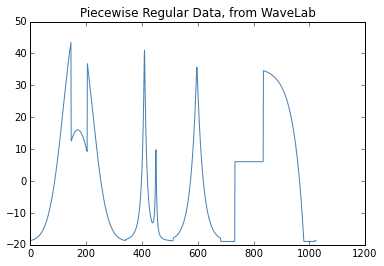

In [3]:
from scipy.io import loadmat
link = 'https://dl.dropboxusercontent.com/u/15378192/piece-regular.mat'
dlname = 'piece-regular.mat'
if not os.path.exists('./%s' % dlname):
    progress_bar_downloader(link, dlname)
else:
    print('%s already downloaded!' % dlname)

data = loadmat(dlname)
pr = data['x']

plt.plot(pr, color='steelblue')
plt.title('Piecewise Regular Data, from WaveLab')

We Have To Go Deeper
--------------------
The filterbank representation of the wavelet (seen [below](http://en.wikipedia.org/wiki/Discrete_wavelet_transform#Cascading_and_Filter_banks)) is very convenient for wavelet peak finding. Extending code from a [previous post](http://kastnerkyle.github.io/blog/2014/02/15/polyphase-signal-processing/), we will create an arbitrary depth anlysis wavelet filterbank (no reconstruction), in order to perform peak detection.

The basic algorithm is detailed in this [whitepaper](http://www.ni.com/white-paper/5432/en/). In short, this method involves finding zero crossings in the level X detail coefficients (generated by the [bior3.1](http://wavelets.pybytes.com/wavelet/bior3.1/) g[n]) where there is less noise in the zero crossings. Tracking those peaks back through the lower levels, we can refine the peak location with higher resolution data. I will use the haar wavelet, mainly because I know how to construct it, so the results will be slightly different than the whitepaper. For non-tutorial use, check out the [PyWavelets package](http://www.pybytes.com/pywavelets/) - it supports a ton of different wavelet functions and is very popular. scipy.signal also has some limited support for wavelet methods.

The NI whitepaper also chooses to use the undecimated wavelet transform - I have chosen to use the decimated version, and compensate for the results. This introduces some noise into the estimates, and may account for some of the "off-by-one" peaks in the results. Hoever, this fits better into the filterbank model for wavelet decomposition.

In [4]:
from IPython.display import Image
Image(url='http://upload.wikimedia.org/wikipedia/commons/2/22/Wavelets_-_Filter_Bank.png')

In [5]:
from numpy.lib.stride_tricks import as_strided

def polyphase_core(x, m, f):
    #x = input data
    #m = decimation rate
    #f = filter
    #Force it to be 1D
    x = x.ravel()
    #Hack job - append zeros to match decimation rate
    if x.shape[0] % m != 0:
        x = np.append(x, np.zeros((m - x.shape[0] % m,)))
    if f.shape[0] % m != 0:
        f = np.append(f, np.zeros((m - f.shape[0] % m,)))
    polyphase = p = np.zeros((m, (x.shape[0] + f.shape[0]) / m), dtype=x.dtype)
    p[0, :-1] = np.convolve(x[::m], f[::m])
    #Invert the x values when applying filters
    for i in range(1, m):
        p[i, 1:] = np.convolve(x[m - i::m], f[i::m])
    return p

def wavelet_lp(data, ntaps=4):
    #type == 'haar':
    f = np.array([1.] * ntaps)
    return np.sum(polyphase_core(data, 2, f), axis=0)

def wavelet_hp(data, ntaps=4):
    #type == 'haar':
    if ntaps % 2 is not 0:
        raise ValueError("ntaps should be even")
    half = ntaps // 2
    f = np.array(([-1.] * half) + ([1.] * half))
    return np.sum(polyphase_core(data, 2, f), axis=0)

def wavelet_filterbank(n, data):
    #Create and store all coefficients to level n
    x = data
    all_lp = []
    all_hp = []
    for i in range(n):
        c = wavelet_lp(x)
        x = wavelet_hp(x)
        all_lp.append(c)
        all_hp.append(x)
    return all_lp, all_hp

def zero_crossing(x):
    x = x.ravel()
    #Create an X, 2 array of overlapping points i.e.
    #[1, 2, 3, 4, 5] becomes
    #[[1, 2],
    #[2, 3],
    #[3, 4],
    #[4, 5]]
    o = as_strided(x, shape=(x.shape[0] - 1, 2), strides=(x.itemsize, x.itemsize))
    #Look for sign changes where sign goes from positive to negative - this is local maxima!
    #Negative to positive is local minima
    return np.where((np.sum(np.sign(o), axis=1) == 0) & (np.sign(o)[:, 0] == 1.))[0]

def peak_search(hp_arr, arr_max):
    #Given all hp coefficients and a limiting value, find and return all peak indices
    zero_crossings = []
    for n, _ in enumerate(hp_arr):
        #2 ** (n + 1) is required to rescale due to decimation by 2 at each level
        #Also remove a bunch of redundant readings due to clip using np.unique
        zero_crossings.append(np.unique(np.clip(2 ** (n + 1) * zero_crossing(hp_arr[n]), 0, arr_max)))

    #Find refined estimate for each peak
    peak_idx = []
    for v in zero_crossings[-1]:
        v_itr = v
        for n in range(len(zero_crossings) - 2, 0, -1):
            v_itr = find_nearest(v_itr, zero_crossings[n])
        peak_idx.append(v_itr)
    #Only return unique answers
    return np.unique(np.array(peak_idx, dtype='int32'))
    
def find_nearest(v, x):
    return x[np.argmin(np.abs(x - v))]
    
def peak_detect(data, depth):
    if depth == 1:
        raise ValueError("depth should be > 1")
    #Return indices where peaks were found
    lp, hp = wavelet_filterbank(depth, data)
    return peak_search(hp, data.shape[0] - 1)

Peaking Duck
------------

One of the trickiest things about this method is choosing the proper depth for wavelet peak detection. Too deep, and sharp peaks may be eliminated due to decimation. Not deep enough, and there may be false positives o spurious results.

Empirically, it appears that the number of taps in the wavelet filter has a similar effect to depth - too many taps seems to blur out sharp peaks, but not enough taps causes strange peaks to be detected. 4 taps seems to be a good number for these two datasets, but this may need tweaking for new applications.

Interestingly enough, changing one line in the ***zero_crossing*** function from:

```return np.where((np.sum(np.sign(o), axis=1) == 0) & (np.sign(o)[:, 0] == 1.))[0]```

to

```return np.where((np.sum(np.sign(o), axis=1) == 0) & (np.sign(o)[:, 0] == -1.))[0]```

changes this from a peak detector (local maximum) into a valley detector (local minimum) - very cool! Though the detected peaks are not perfect, they are pretty close and could probably be improved by choosing a better wavelet, or better estimation of the proper depth parameter.

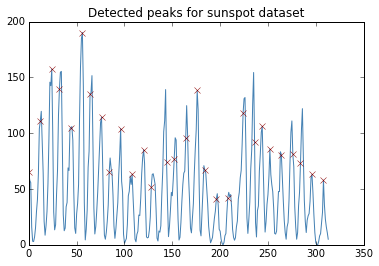

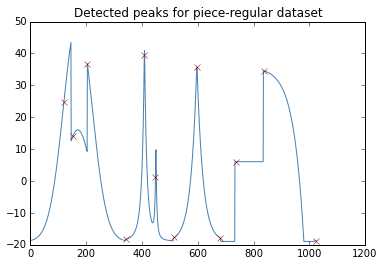

In [6]:
indices = peak_detect(sunspot, 2)
plt.title('Detected peaks for sunspot dataset')
plt.plot(sunspot, color='steelblue')
plt.plot(indices, sunspot[indices], 'x', color='darkred')
plt.figure()
indices = peak_detect(pr, 3)
plt.title('Detected peaks for piece-regular dataset')
plt.plot(pr, color='steelblue')
plt.plot(indices, pr[indices], 'x', color='darkred')

Denoise and Defury
------------------

To complete our tour of wavelets, it would be beneficial to show how wavelets can be used for denoising as well. For this application, I will use the [matrix representation](http://yjlego.wordpress.com/2009/11/25/wavelet-transformation-from-a-matrix-point-of-view/) of the wavelet basis, rather than the filterbank interpretation. Though they should be equivalent, the block transform is more straightforward (IMO) if you do not need the intermediate coefficients, as we did in the peak detection application. The [MATLAB code](http://www.mathworks.com/matlabcentral/fileexchange/33625-haar-wavelet-transformation-matrix-implementation/content/ConstructHaarWaveletTransformationMatrix.m) is also a useful resource.

The general idea is to transform the input signal, then remove noise using a soft threshold in the transform space. This will zero out small coefficients, while larger coefficients will remain unaltered. Following this thresholding operation with the inverse wavelet transform we will get a filtered version of the original signal. Because each wavelet contains many different frequencies, this type of filtering can better preserve edges and trends than a simple highpass or lowpass filter. Let's check it out.

In [7]:
def haar_matrix(size):
    level = int(np.ceil(np.log2(size)))
    H = np.array([1.])[:, None]
    NC = 1. / np.sqrt(2.)
    LP = np.array([1., 1.])[:, None] 
    HP = np.array([1., -1.])[:, None]
    for i in range(level):
        H = NC * np.hstack((np.kron(H, LP), np.kron(np.eye(len(H)),HP)))
    H = H.T
    return H

def dwt(x):
    H = haar_matrix(x.shape[0])
    x = x.ravel()
    #Zero pad to next power of 2
    x = np.hstack((x, np.zeros(H.shape[1] - x.shape[0])))
    return np.dot(H, x)

def idwt(x):
    H = haar_matrix(x.shape[0])
    x = x.ravel()
    #Zero pad to next power of 2
    x = np.hstack((x, np.zeros(H.shape[0] - x.shape[0])))
    return np.dot(H.T, x)

def wthresh(a, thresh):
    #Soft threshold
    res = np.abs(a) - thresh
    return np.sign(a) * ((res > 0) * res)

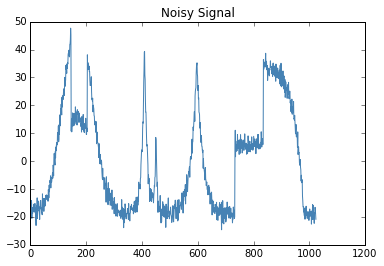

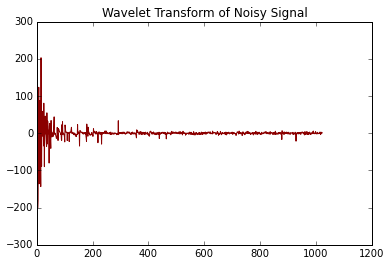

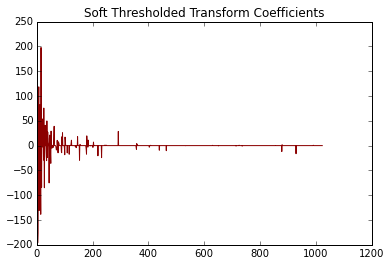

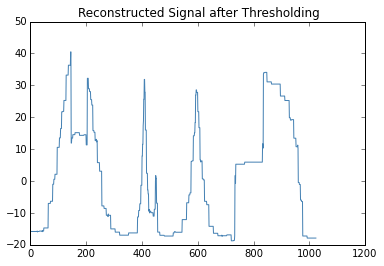

In [8]:
rstate = np.random.RandomState(0)
s = pr + 2 * rstate.randn(*pr.shape)
threshold = t = 5
wt = dwt(s)
wt = wthresh(wt, t)
rs = idwt(wt)

plt.plot(s, color='steelblue')
plt.title('Noisy Signal')
plt.figure()
plt.plot(dwt(s), color='darkred')
plt.title('Wavelet Transform of Noisy Signal')
plt.figure()
plt.title('Soft Thresholded Transform Coefficients')
plt.plot(wt, color='darkred')
plt.figure()
plt.title('Reconstructed Signal after Thresholding')
plt.plot(rs, color='steelblue')

The Compression Dimension
-------------------------

The use of wavelets for compression is basically identical to its use for filtering. Keep the most powerful coefficients, while zeroing out everything else. On reconstruction, the result will be very close to the original, and much closer than if you attempted the same thing with a DFT. I am not sure how this compares to DCT compression, but the visual result seems pretty good to me.

lena.gif already downloaded!


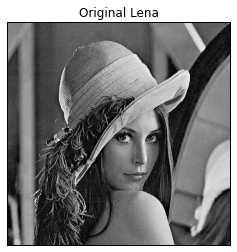

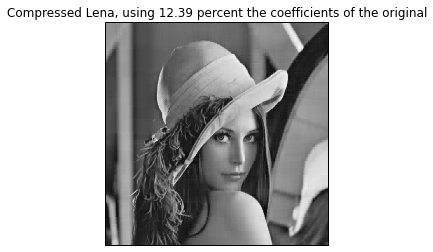

In [9]:
from scipy import misc
link = 'http://sipi.usc.edu/~ortega/icip2001/original/lena_512.gif'
dlname = 'lena.gif'
if not os.path.exists('./%s' % dlname):
    progress_bar_downloader(link, dlname)
else:
    print('%s already downloaded!' % dlname)
    
def dwt2d(x):
    H = haar_matrix(x.shape[0])
    return np.dot(np.dot(H, x), H.T)       

def idwt2d(x):
    H = haar_matrix(x.shape[0])
    return np.dot(np.dot(H.T, x), H)       

lena = misc.imread(dlname)
wt = dwt2d(lena)
thresh = wthresh(wt, 15)
rs = idwt2d(thresh)

wtnz = len(wt.nonzero()[0]) + len(wt.nonzero()[1])
rsnz = len(thresh.nonzero()[0]) + len(thresh.nonzero()[1])

reduction = 'using %.2f percent the coefficients of the original' % (100 * float(rsnz) / wtnz)

plt.imshow(lena, cmap='gray')
f = plt.gca()
f.axes.get_xaxis().set_visible(False)
f.axes.get_yaxis().set_visible(False)
plt.title('Original Lena')
plt.figure()
plt.imshow(rs, cmap='gray')
f = plt.gca()
f.axes.get_xaxis().set_visible(False)
f.axes.get_yaxis().set_visible(False)
plt.title('Compressed Lena, %s' % reduction)

Wavelets are a very interesting and powerful tool for signal processing and machine learning, and I hope this post has brought some clarity to the subject.

kk